<a href="https://colab.research.google.com/github/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/blob/main/Ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz

     |████████████████████████████████| 1.5MB 4.2MB/s 
     |████████████████████████████████| 737kB 42.9MB/s 
     |████████████████████████████████| 4.7MB 36.1MB/s 
     |████████████████████████████████| 296kB 42.0MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [2]:
!pip install pymc3==3.8

     |████████████████████████████████| 911kB 4.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [7]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from sklearn import preprocessing

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [28]:
def plot(x, y, mu_pred, y_pred, alpha, ax, title, x_label, y_label):
  idx = np.argsort(x.values)
  x_ord = x.values[idx]
  y_pred_hpd_ord = az.hdi(y_pred, alpha)[idx]
  mu_hpd_ord = az.hdi(mu_pred, alpha)[idx]
  mu_mean_ord = np.mean(mu_pred, axis=0)[idx]

  ax.scatter(x, y, c='C0', alpha=0.3)
  ax.plot(x_ord, mu_mean_ord, color='C2')
  ax.fill_between(x_ord, mu_hpd_ord[:,0], mu_hpd_ord[:,1], color='C2', alpha=0.25)
  ax.fill_between(x_ord, y_pred_hpd_ord[:,0], y_pred_hpd_ord[:,1], color='C2', alpha=0.25)
  ax.set_xlabel(x_label, fontsize=14)
  ax.set_ylabel(y_label, fontsize=14)
  ax.set_title(title, fontsize=20)

In [11]:
# Import Data
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/WaffleDivorce.csv'
d = pd.read_csv(url, sep=';')
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [12]:
# Standarized Data
scaler = preprocessing.StandardScaler()
scaler.fit(d[['Divorce', 'Marriage', 'MedianAgeMarriage']])
d[['Divorce', 'Marriage', 'MedianAgeMarriage']] = scaler.transform(d[['Divorce', 'Marriage', 'MedianAgeMarriage']])
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,-0.612445,0.022874,1.27,1.671000,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,-0.693671,1.565536,2.93,1.560044,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,-0.206314,0.049472,0.98,0.616916,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,-1.424706,1.671927,1.70,2.114824,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,0.605947,-0.269700,0.39,-0.936470,0.24,0,0,0,379994,0.00


In [17]:
# Model Divorce Rate vs Median Age Marriage
with pm.Model() as model_5_1:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  betaA = pm.Normal('betaA', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + betaA * d.MedianAgeMarriage)
  divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
  trace_5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, betaA, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1478.67it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f35dc5eda58>,
      dtype=object)

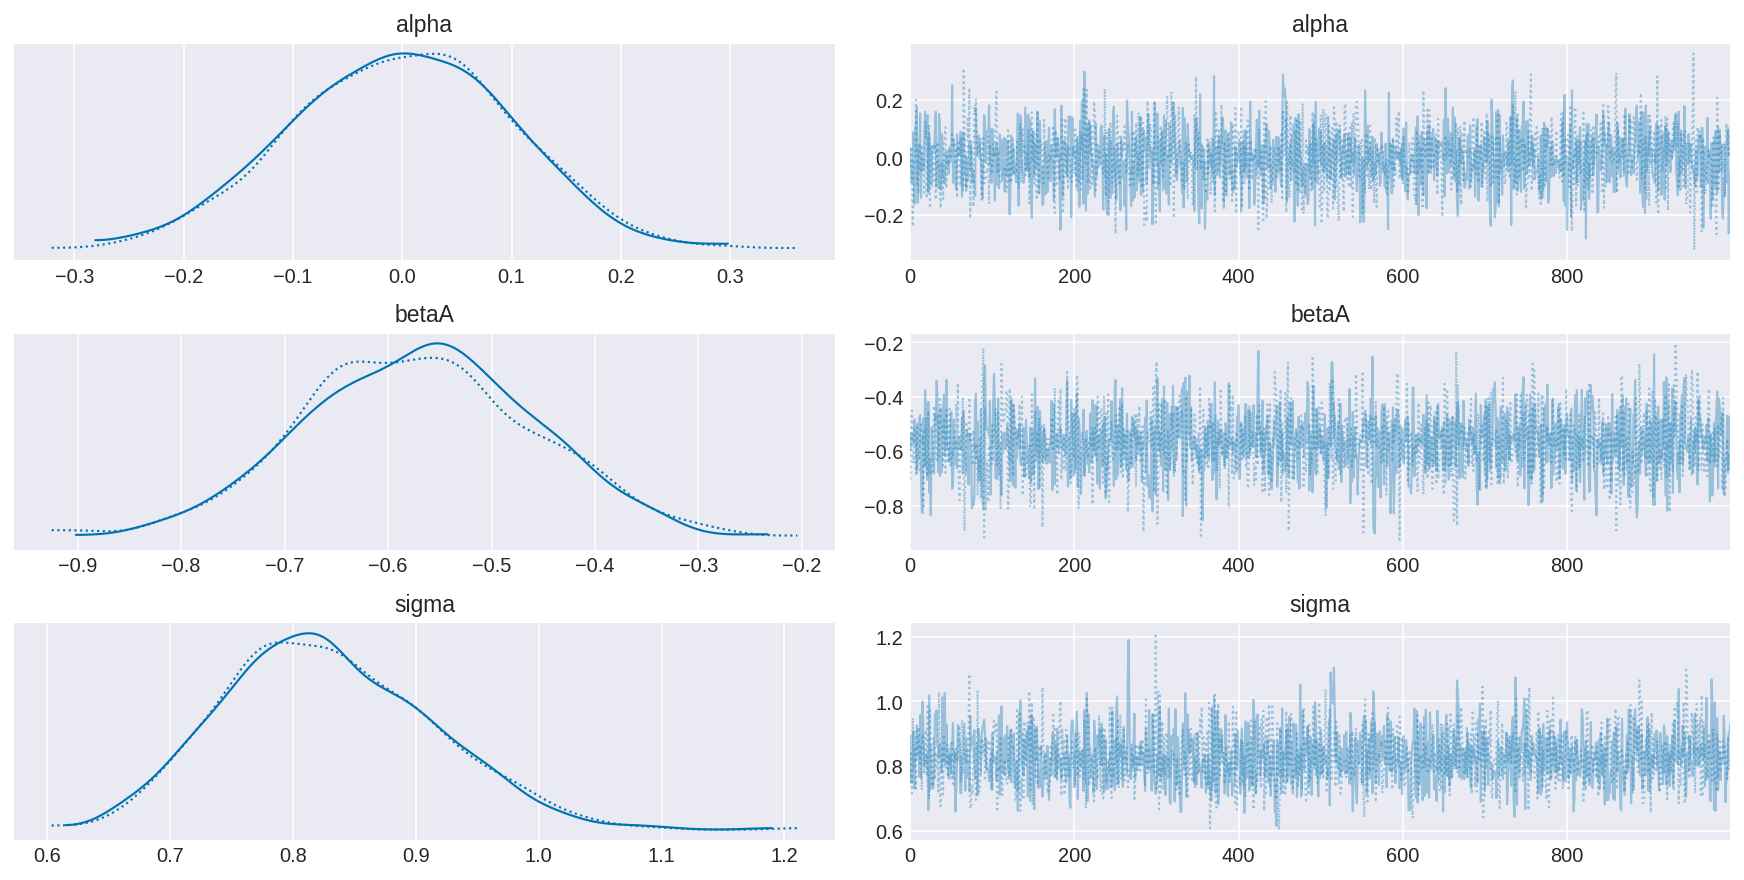

In [19]:
pm.traceplot(trace_5_1, var_names=['alpha', 'betaA', 'sigma'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f35dc5ed2e8>],
      dtype=object)

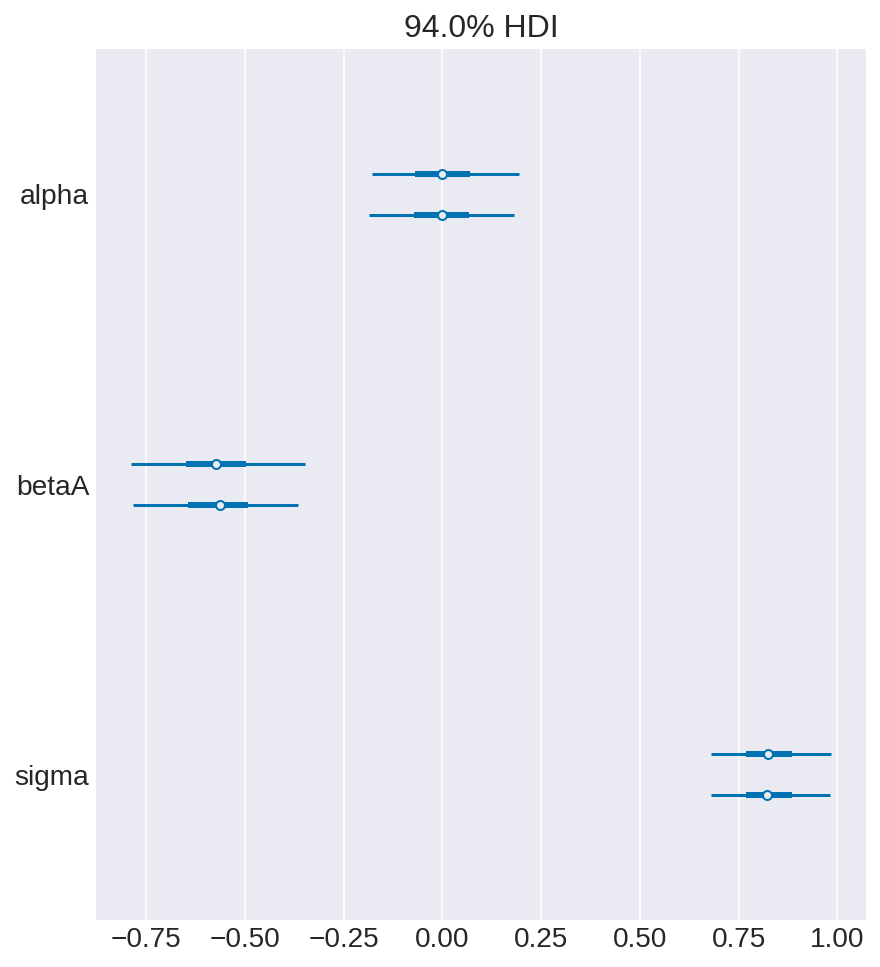

In [45]:
pm.forestplot(trace_5_1, var_names=['alpha', 'betaA', 'sigma'])

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 772.25it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


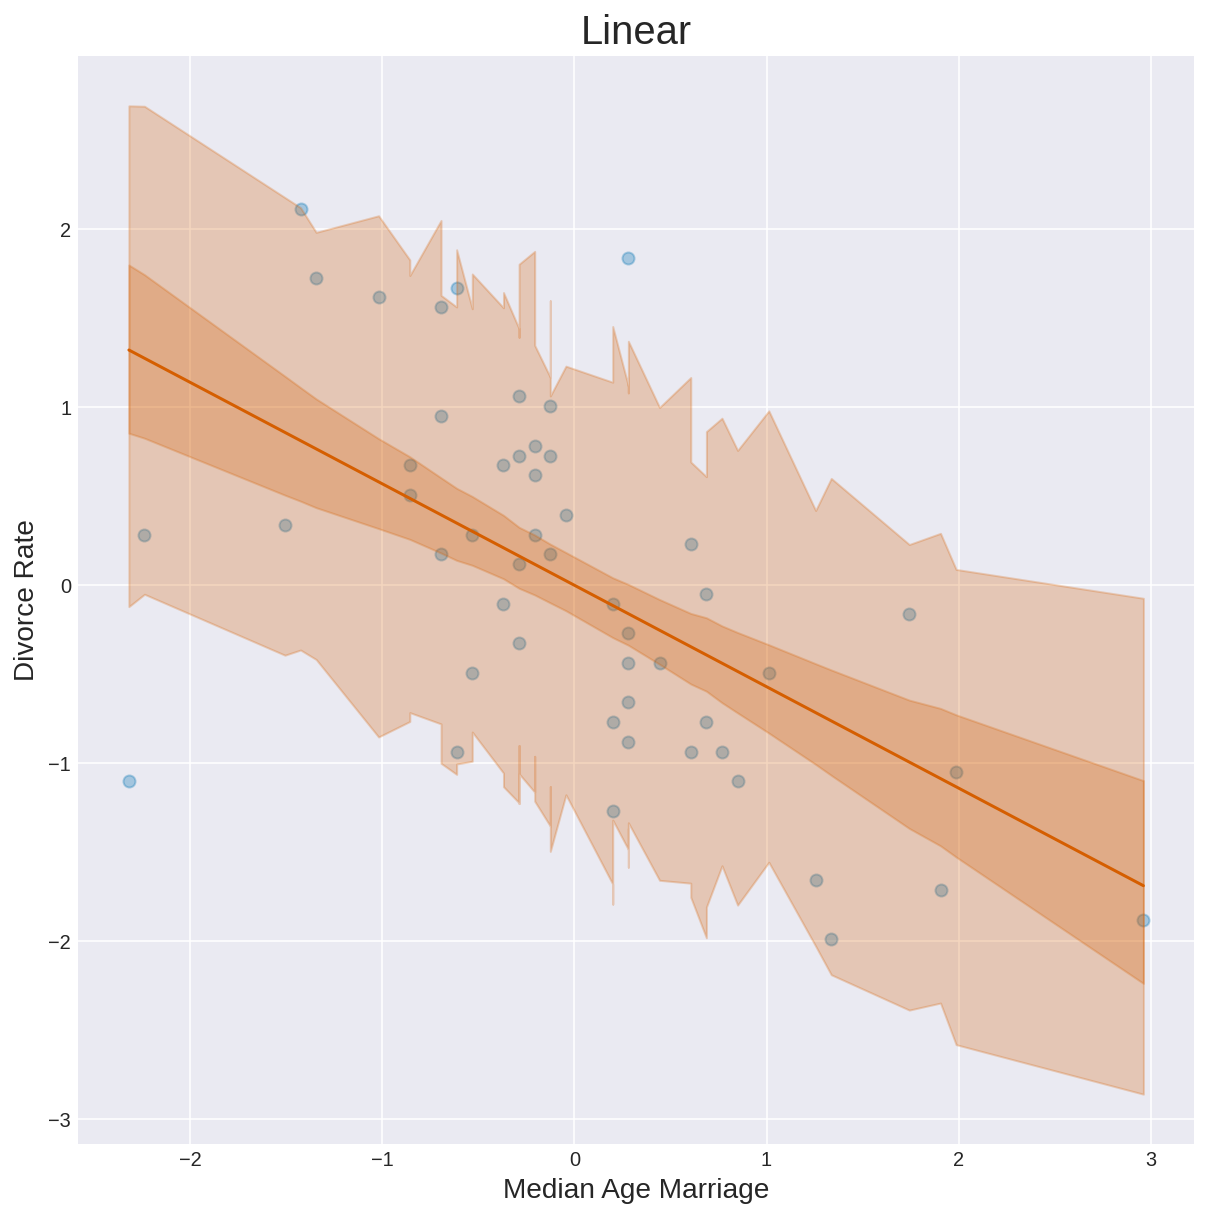

In [29]:
mu_pred = trace_5_1['mu']
y_pred = pm.sample_posterior_predictive(trace_5_1, 200, model_5_1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d.MedianAgeMarriage, d.Divorce, mu_pred, y_pred['divorce'], 0.9, ax, 'Linear', 'Median Age Marriage', 'Divorce Rate')

In [30]:
# Model Divorce Rate vs Marriage
with pm.Model() as model_5_6:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  betaA = pm.Normal('betaA', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + betaA * d.Marriage)
  divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
  trace_5_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, betaA, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1403.98it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f35d0cd54e0>,
      dtype=object)

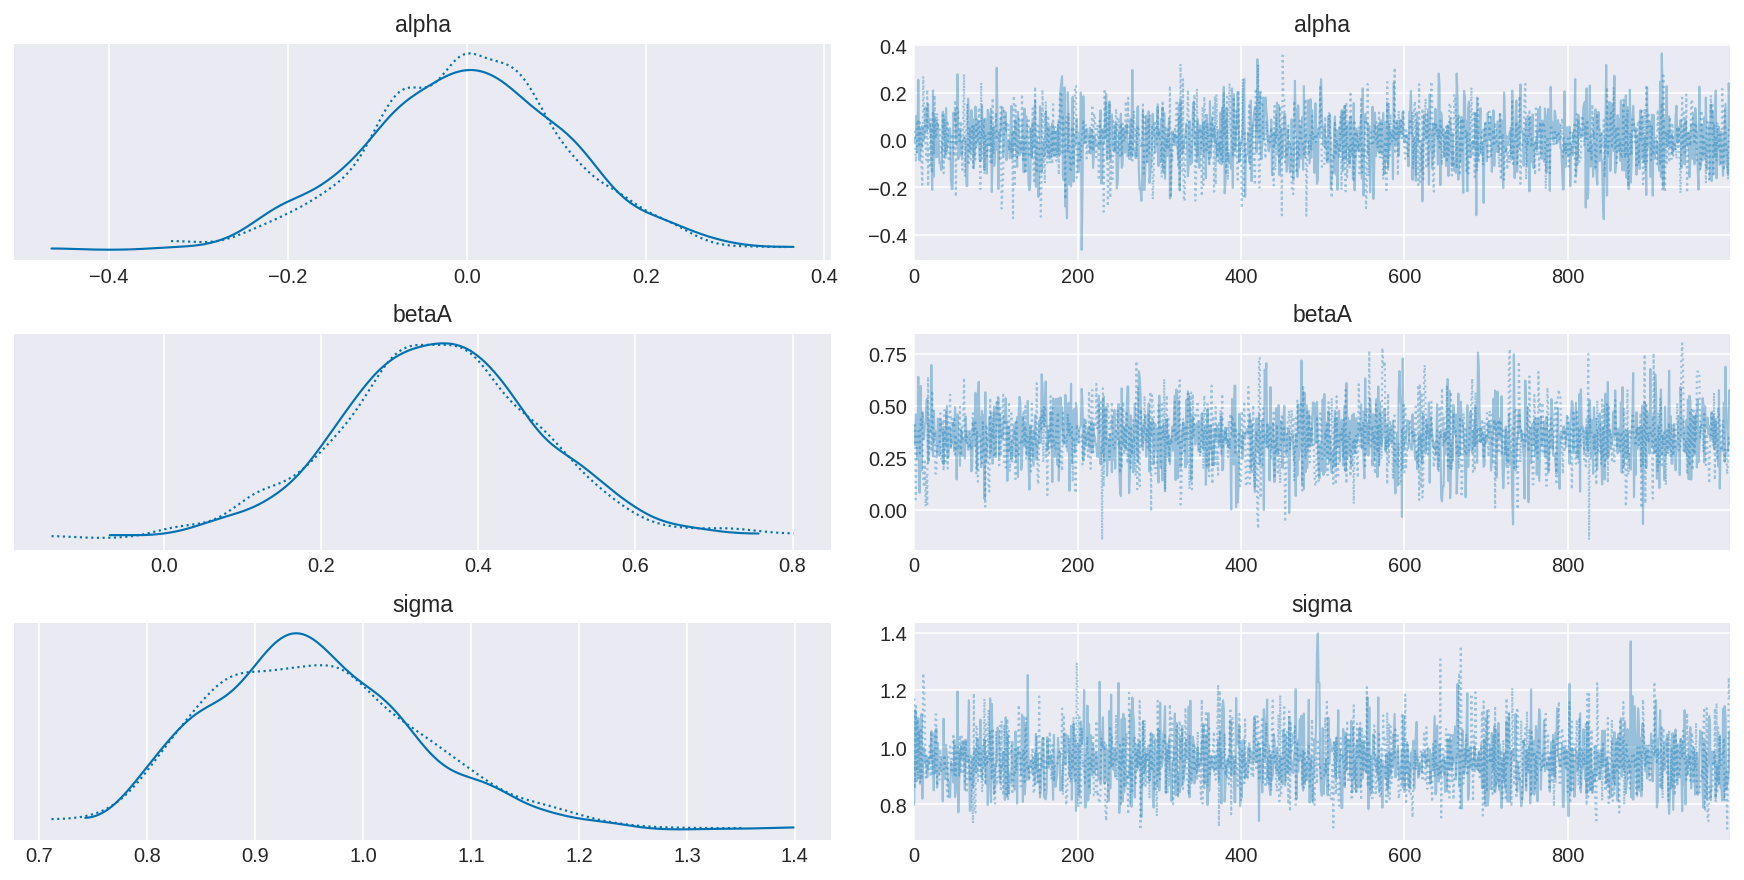

In [46]:
pm.traceplot(trace_5_6, var_names=['alpha', 'betaA', 'sigma'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f35d2116630>],
      dtype=object)

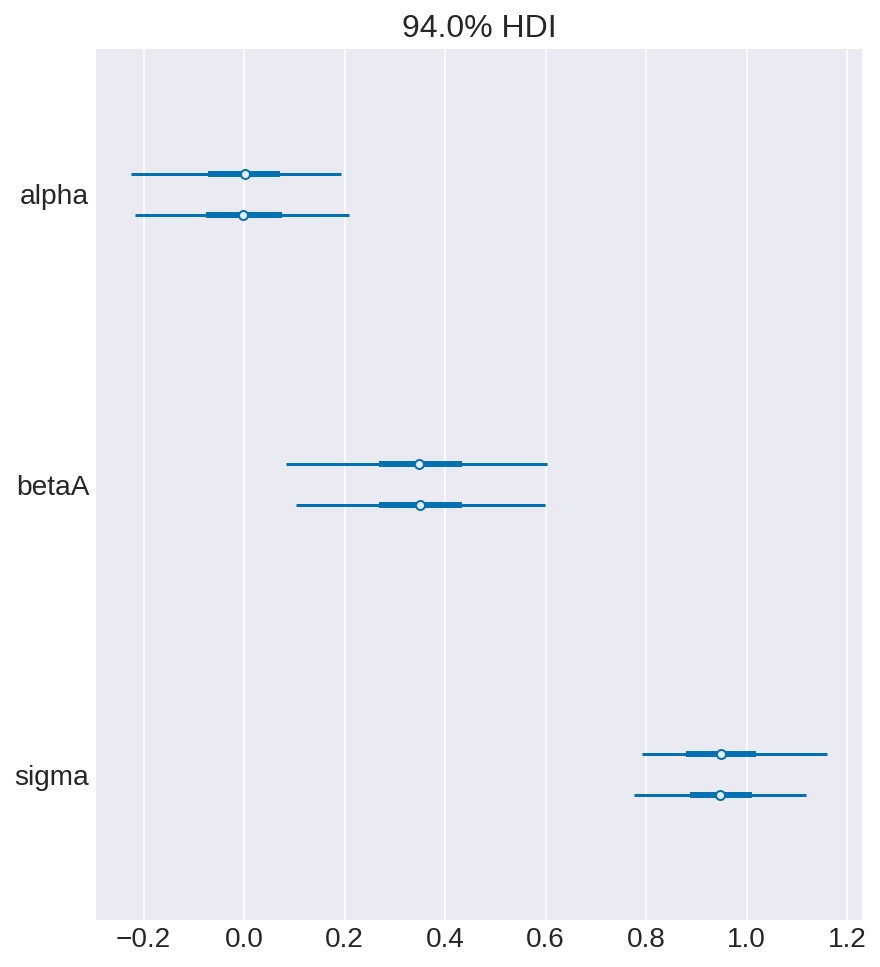

In [47]:
pm.forestplot(trace_5_6, var_names=['alpha', 'betaA', 'sigma'])

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 743.56it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


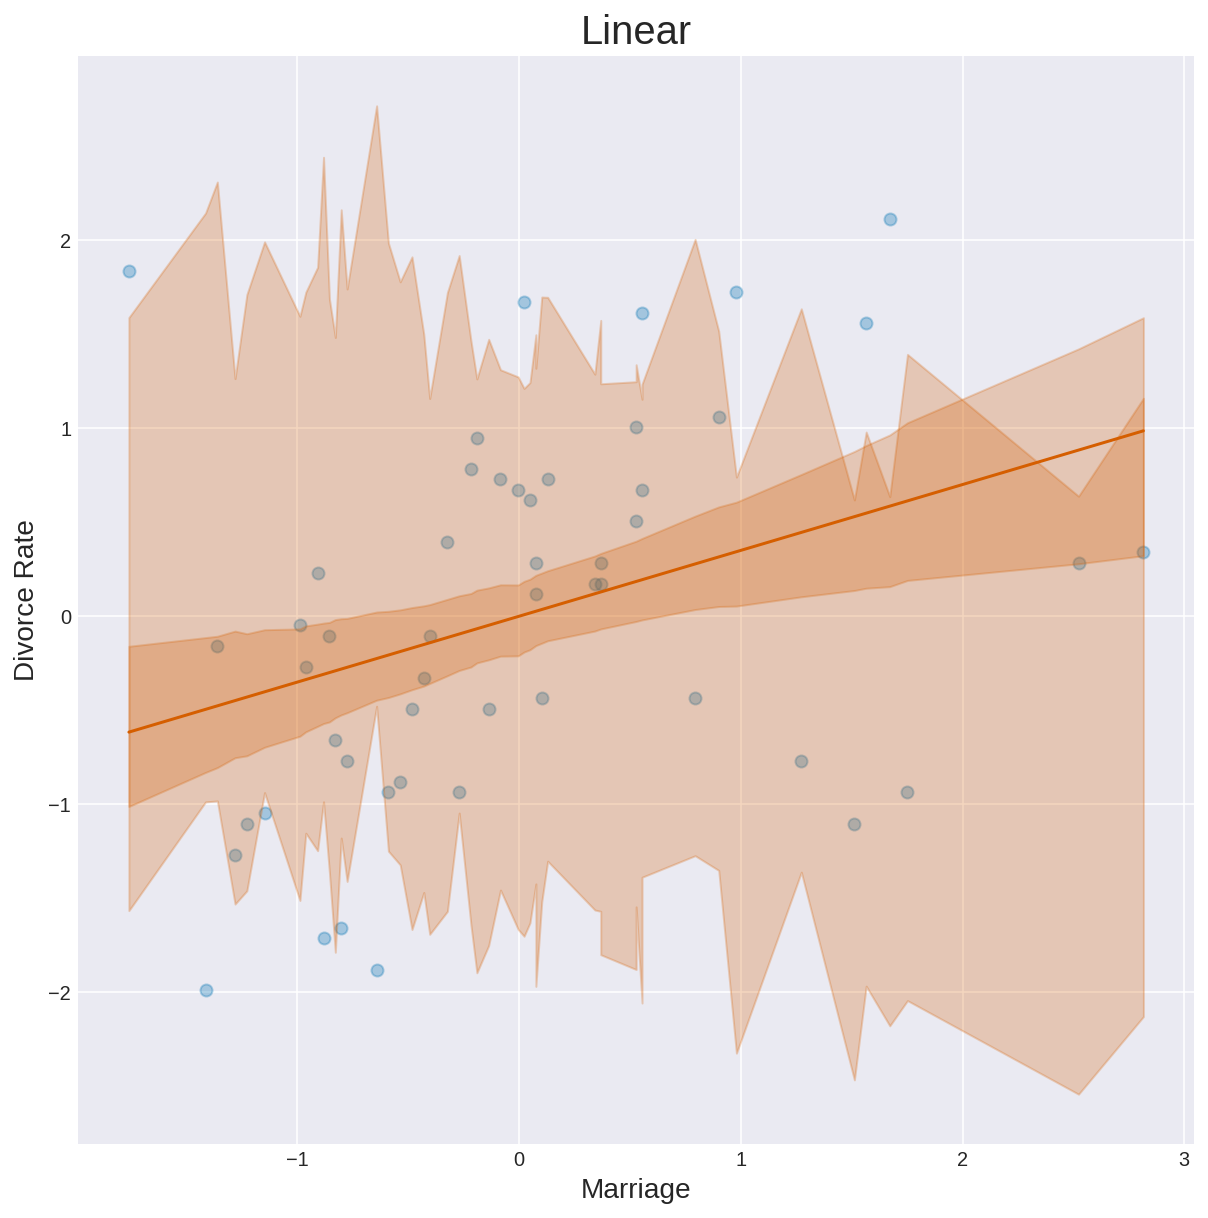

In [33]:
mu_pred = trace_5_6['mu']
y_pred = pm.sample_posterior_predictive(trace_5_6, 200, model_5_1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d.Marriage, d.Divorce, mu_pred, y_pred['divorce'], 0.9, ax, 'Linear', 'Marriage', 'Divorce Rate')

## Multiple Regression

In [39]:
# 5.10
with pm.Model() as model_5_10:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  beta = pm.Normal('beta', mu=0, sd=0.5, shape=2)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + beta[0] * d.Marriage + beta[1] * d.MedianAgeMarriage)
  divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
  trace_5_10 = pm.sample(10000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:10<00:00, 1017.73it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f35d1b903c8>,
      dtype=object)

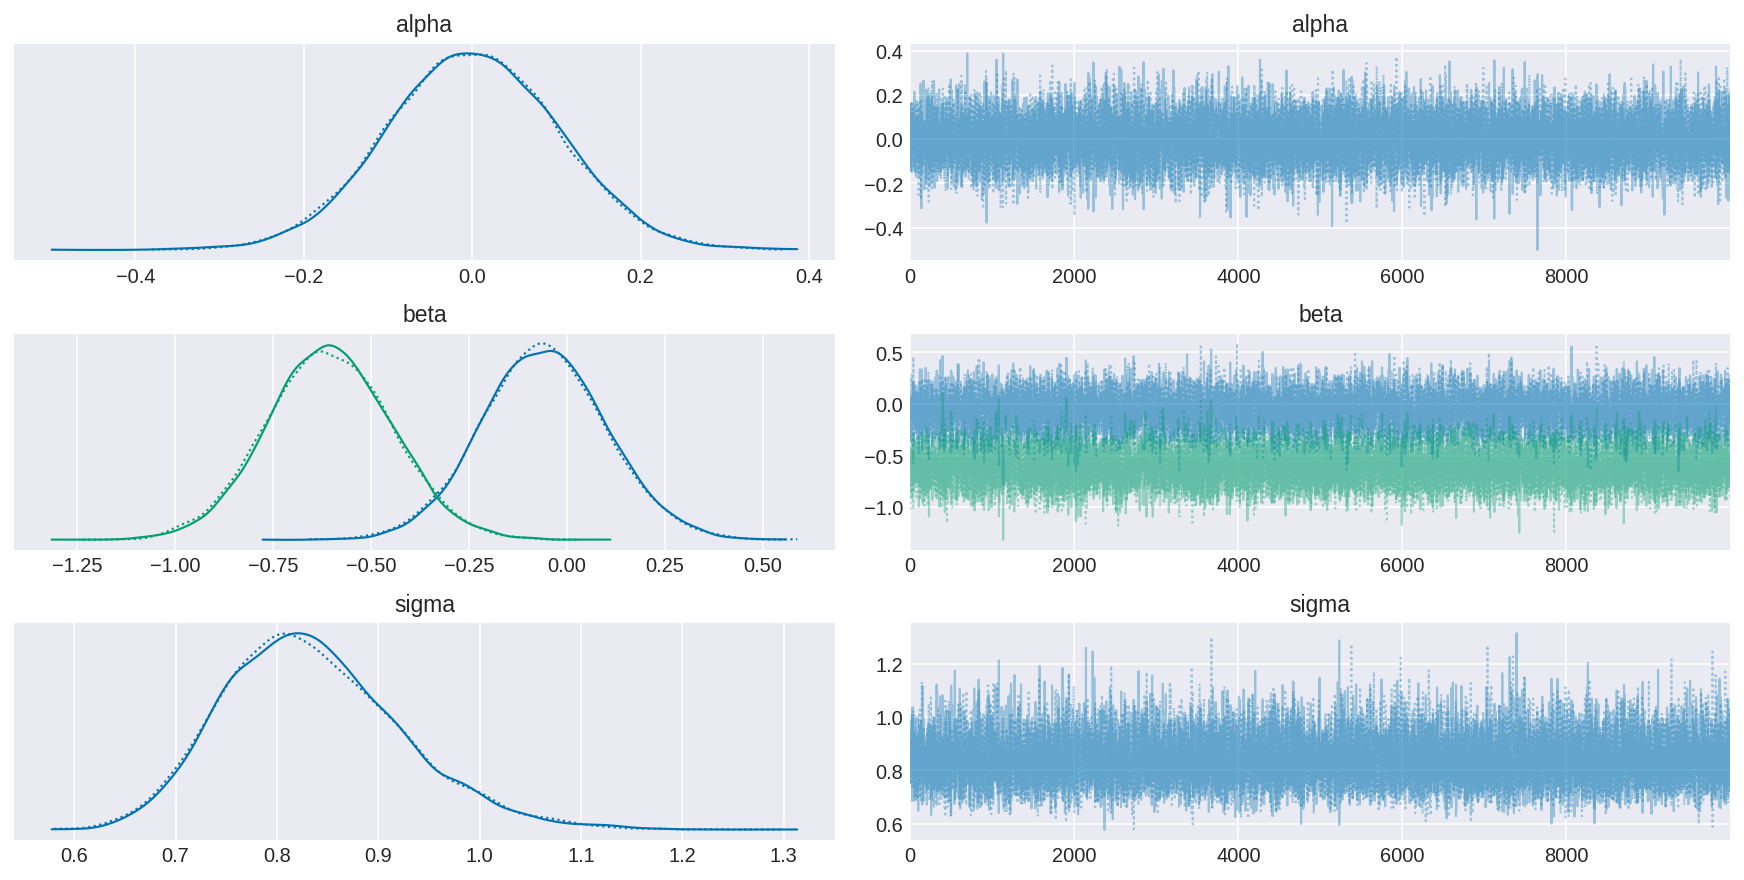

In [40]:
pm.traceplot(trace_5_10, var_names=['alpha', 'beta', 'sigma'])

In [42]:
pm.summary(trace_5_10, var_names=['alpha', 'beta', 'sigma']).round(3)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.102,-0.189,0.191,0.001,0.001,16486.0,9879.0,16498.0,13999.0,1.0
beta[0],-0.061,0.160,-0.356,0.247,0.001,0.001,12466.0,11335.0,12484.0,13373.0,1.0
beta[1],-0.607,0.160,-0.903,-0.304,0.001,0.001,12882.0,12867.0,12900.0,13497.0,1.0
sigma,0.836,0.089,0.681,1.007,0.001,0.001,15099.0,14905.0,15230.0,12617.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f35d7f4c0f0>],
      dtype=object)

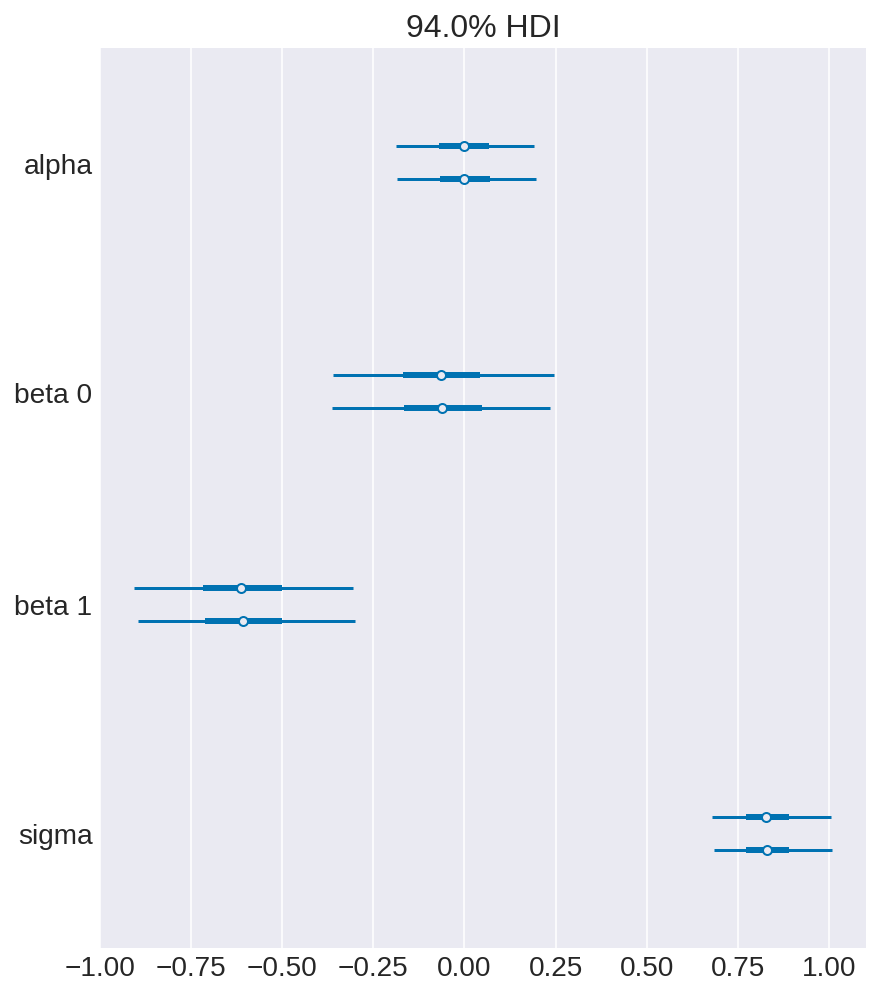

In [43]:
pm.forestplot(trace_5_10, var_names=['alpha', 'beta', 'sigma'])

beta_1 for Age is not changing compare to the previous model while the beta_0 for Merrige is changing from positive value to almost zero.